In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import soundfile as sf
import librosa.display
from glob import glob
import os
from tqdm import tqdm

In [ ]:
def splitData(X, t, testFraction=0.2, randomize = False):
    """
    Split the data randomly into training and test sets
    Use numpy functions only
    Inputs:
        X: (np array of len Nsamples) input feature vectors
        t: (np array of len Nsamples) targets; one hot vectors
        testFraction: (float) Nsamples_test = testFraction * Nsamples
    Outputs:
        X_train: training set
        X_test: test set
        t_train: training labels
        t_test: test labels
    """
    if randomize is False:
      tot_samples = np.random.RandomState(seed=42).permutation(len(X))
    else:
      tot_samples = np.random.permutation(len(X))

    X_train = []
    X_test = []
    t_train = []
    t_test = []
    
    test_samples = max(1,int(len(X)*testFraction))
    # print(tot_samples[:test_samples])
    # print(tot_samples[test_samples:])

    for i in range(test_samples):
      X_test.append(X[tot_samples[i]])
      t_test.append(t[tot_samples[i]])

    for i in range(test_samples,len(X)):
      X_train.append(X[tot_samples[i]])
      t_train.append(t[tot_samples[i]])
    
    return np.asarray(X_train), np.asarray(t_train), np.asarray(X_test), np.asarray(t_test)

def calc_spec(x):
    n_fft = 1024
    hop_length = 512
    win_length = 1024
    X = np.abs(librosa.stft(x, n_fft = n_fft, hop_length = hop_length, win_length = win_length, window='hann'))
    X = librosa.power_to_db(X**2,ref=np.max)
    return X

def audio2spec(x, norm=True):
    
    '''
    Compute Mel-frequency cepstral coefficients (MFCCs)
    Inputs:
        x: np array of shape (Nsamples,)
    Output:
        X: (np array) spectrogram sequence
    '''
    X=[]
    for sample in x:
      X.append(calc_spec(sample))
    if norm is True:
      X = (X-np.mean(X))/np.std(X)
    return np.asarray(X)

In [ ]:
def computeCM(y, y_hat):
    '''
    Compute confusion matrix to evaluate your model
    Inputs:
        y = labels 
        y_hat = predicted output
    Output:
        confusion matrix: confusion matrix
    '''
    tp=0
    tn=0
    fp=0
    fn=0

    for i in range(len(y)):
      if y[i][0] == 1 and y_hat[i][0] == 1:
        tp+=1
      elif y[i][0] == 0 and y_hat[i][0] == 0:
        tn+=1
      elif y[i][0] == 1 and y_hat[i][0] == 0:
        fn+=1
      elif y[i][0] == 0 and y_hat[i] == 1:
        fp+=1

    confusion_matrix = [[tp,fp],[fn,tn]]
    return np.asarray(confusion_matrix) 

In [ ]:
!pip install noisereduce

In [ ]:
import librosa
import os
import noisereduce as nr
import glob
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
from collections import defaultdict
import soundfile as sf
from tqdm import tqdm

In [ ]:
def is_overlap(cstart_time, cend_time, start_time, end_time):
  if(cstart_time > end_time):
    return False
  if(cend_time < start_time):
    return False
  if(start_time > cstart_time and end_time < cend_time ):
    return True
  if(start_time > cstart_time):
    overlap = start_time - cstart_time
    if(overlap > 0.50 * (start_time - cend_time)):
      return True
    else:
      return False
  if(end_time < cend_time):
    overlap = cend_time - end_time
    if(overlap > 0.50 * (start_time - cend_time)):
      return True
    else:
      return False
  
  return True

def one_hot_enc(cl_name):
  if(cl_name == 'music'):
    return np.array([0,1,0])
  elif(cl_name == 'speech'):
    return np.array([1,0,0])
  else:
    return np.array([0,0,1])


def load_audio(filename, cls, Fs = 16000):
    # Return bins of size of 1000 corresponding to 
    x, _ = librosa.load(filename, sr=Fs)
    x = nr.reduce_noise(x, Fs)
    x = np.reshape(x[:K], (-1,SPLIT_SIZE))
    labels = np.zeros((N,3))
    for index, sub_audios in enumerate(x):
      class_assigned = False
      for tup in enumerate(cls):
        if(is_overlap(tup[1][0], tup[1][1], index*SPLIT_SIZE/K, (index+1)*SPLIT_SIZE/K)):
          labels[index] = one_hot_enc(tup[1][2])
          class_assigned = True
          break
      if(class_assigned == False):
          labels[index] = one_hot_enc('silence')
    
    return labels, x


def load_data(foldername, Fs=16000):
  '''
  Inputs: 
      foldername: (str) foldername
      Fs: (int) sampling rate
  
  Output:
      data: np array of data
  '''

  files = os.listdir(foldername+'/wav')
  df = pd.read_csv (foldername+'/labels.csv', usecols=['filename','onset','offset','class'])
  print(df.head())
  labels_data = df.to_numpy()
  data = dict()
  labels = defaultdict(list)
  
  for entry in labels_data:
    # print(entry[0])
    # print((entry[1],entry[2],entry[3]))
    labels[entry[0]].append((entry[1],entry[2],entry[3]))
  
  labels_list = []
  data_list = []

  for wav_file in tqdm(files):
    ls, audio = load_audio(foldername+"/wav/"+wav_file, labels[wav_file[:-4]], Fs)
    labels_list.append(ls)
    data_list.append(audio)

  labels_final = np.array(labels_list)
  data_final = np.array(data_list)
  labels_final = labels_final.reshape(N*len(files), 3)
  data_final = data_final.reshape(N*len(files), SPLIT_SIZE)
  # print(labels_final.shape)
  # print(data_final.shape)
  return labels_final, data_final


def reverse_one_hot(ohv):
  if(ohv[1] == 1):
    return "music"
  elif(ohv[0] == 1):
    return "speech"
  else:
    return "silence"

def save_data(train_labels, train_audios):
  for i in range(len(train_audios)):
    print(reverse_one_hot(train_labels[i]))
    sf.write('/content/drive/MyDrive/Sem 5/EE603/project/val_set/split_wavs/'+str(i)+'.wav', train_audios[i], 16000)

def get_mfcc(train_audios, n_mfcc=20, Fs=16000):
    mfccs=[]
    for audio in tqdm(train_audios):
      mfccs.append(librosa.feature.mfcc(audio, n_mfcc=n_mfcc, sr=Fs, n_fft=512))
      # mfccs.append(audio_mfcc)
    mfccs = np.array(mfccs)
    return mfccs

In [ ]:
SAMPLING_RATE = 16000
AUDIO_DURATION = 10 #in seconds
FRAME_ACCURACY = 0.99
SPLIT_SIZE = 1000
MAX_SAMPLES = 0
K = int(AUDIO_DURATION*SAMPLING_RATE*FRAME_ACCURACY/SPLIT_SIZE)*SPLIT_SIZE
N = int(K/SPLIT_SIZE)

In [ ]:
train_labels, train_audios = load_data('/content/drive/MyDrive/Sem 5/EE603/project/val_set')

  filename   onset  offset   class
0     S001  0.7545   1.963  speech
1     S001  3.0330   4.365  speech
2     S001  5.2850   6.591  speech
3     S001  7.6340   9.019  speech
4     S002  0.1580   1.060  speech


100%|██████████| 30/30 [00:15<00:00,  1.88it/s]


In [ ]:
print(np.shape(train_labels), type(train_labels))
print(np.shape(train_audios), type(train_audios))

(4740, 3) <class 'numpy.ndarray'>
(4740, 1000) <class 'numpy.ndarray'>


In [ ]:
class Classifier: 
    '''
    Create a linear classifier to classify each frame
    '''
    def __init__(self,lr=10**-2,epoch=10**4):
        self.W = -1
        self.b = 0
        self.lr = lr
        self.epoch = epoch

    def softMax(self,z):
      z = np.exp(z - np.max(z))
      return z/np.sum(z)

    def train(self,x_train, y_train):
        '''
        Train the linear classifier
        Inputs:
            x_train: training set
            y_train: training labels
        Output:
            None
        '''
        print("Received input data and labels of shapes:",np.shape(x_train), np.shape(y_train))
        n_files = np.shape(x_train)[0]
        n_features = np.shape(x_train)[1]
        n_frames = np.shape(x_train)[2]
        n_classes = np.shape(y_train)[1]
        m = n_files

        print(n_files, "n_files")
        print(n_frames, "n_frames")
        print(n_features, "n_features")
        print(n_classes, "n_classes")

        self.W = np.random.RandomState(seed=42).random((n_features, n_classes))
        self.b = np.random.RandomState(seed=42).random(n_classes)
        print("Initialised weights and bias with shapes:", np.shape(self.W), np.shape(self.b))

        X = []
        Y = []
        losses = []

        for i in range(n_files):
          for j in range(n_frames):
            X.append(x_train[i][:,j])
            Y.append(y_train[i])

        X = np.asarray(X)
        Y = np.asarray(Y)
        print("final shapes of data fed to training:",np.shape(X),np.shape(Y))

        for i in tqdm(range(self.epoch)):
            Z = X@self.W + self.b
            Y_hat = self.softMax(Z)

            w_grad = (1/m)*np.dot(X.T, (Y_hat - Y)) 
            b_grad = (1/m)*np.sum(Y_hat - Y)
            
            self.W -= self.lr*w_grad
            self.b -= self.lr*b_grad
            
            # loss = (-1/m)*np.sum(np.log(Y_hat+1e-9)*Y )
            loss = -np.mean(np.log(1e-10+Y_hat[np.arange(len(Y)), np.argmax(Y, axis=1)]))

            losses.append(loss)
        return losses       

    def save_model(self, save_path):
        '''
        Save the trained model on local disk
        Input:
            save_path: location at which model is to be saved
        Output:
            None
        '''
        
        with open(os.path.join(save_path,'W.npy'), 'wb') as f:
          np.save(f,self.W)
        with open(os.path.join(save_path,'b.npy'), 'wb') as f:
          np.save(f,self.b)
    
    def load_model(self, load_path):
        '''
        Save the trained model on local disk
        Input:
            load_path: location from which model is to be loaded
        Output:
            None
        '''

        with open(os.path.join(load_path,'W.npy'), 'rb') as f:
          self.W = np.load(f)
        with open(os.path.join(load_path,'b.npy'), 'rb') as f:
          self.b = np.load(f)
    
    def predict_framewise(self,x_test):
        '''
        Framewise classification (speech or music)
        Input:
            x_test: single frame (n_features,1)
        Output:
            y_pred_framewise = class prediction
        '''
        z = x_test@self.W + self.b
        y_hat = np.argmax(self.softMax(z))
        y_hot = np.zeros(np.shape(z)[0])
        y_hot[y_hat] = 1
        return y_hot

    def predict_aggregate(self,y_pred_framewise):
        '''
        Aggregate frames to give a single class label (music or speech) to the entire audio file
        Input:
            y_pred_framewise: framewise prediction
        Output:
            y_hat: frame aggregate (one-hot vectors)
        '''
        y_pred_framewise = np.asarray(y_pred_framewise)
        if y_pred_framewise.ndim > 1:
          counts = np.sum(y_pred_framewise, axis=0)
        y_hat = np.argmax(counts)
        y_hot = np.zeros(np.shape(counts)[0])
        y_hot[y_hat] = 1
        return y_hot

    def predict(self,x_test):
      '''
      Return one hot encoded classification results for the test set
      Input: 
        x_test: testing set (normalised spectrograms)
      Output:
        y_hat: list of one hot vectors for classification on x_test
      '''
      y_hat = []
      for f in x_test:
        y_pred_framewise = []
        for window in range(np.shape(f)[1]):
          y_pred_framewise.append(self.predict_framewise(f[:,window]))
        y_hat.append(self.predict_aggregate(y_pred_framewise))
      return y_hat

check shapes after train test split
(3792, 1000) (3792, 3)
(948, 1000) (948, 3)


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=1024 is too small for input signal of length=1000
  n_fft, y.shape[-1]


training
Received input data and labels of shapes: (3792, 1026, 1) (3792, 3)
3792 n_files
1 n_frames
1026 n_features
3 n_classes
Initialised weights and bias with shapes: (1026, 3) (3,)
final shapes of data fed to training: (3792, 1026) (3792, 3)


100%|██████████| 1000/1000 [00:37<00:00, 26.35it/s]


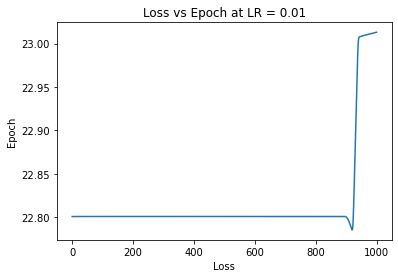

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=1024 is too small for input signal of length=1000
  n_fft, y.shape[-1]


In [ ]:
EPOCHS = 10**3
LR = 10**-2
TESTFRACTION = 0.2

# train_audios_mfcc = audio2spec(train_audios)
# print(np.shape(train_audios_mfcc), type(train_audios_mfcc))
# train_audios_mfcc = np.reshape(train_audios_mfcc, (np.shape(train_audios_mfcc)[0],-1,1))
# print(np.shape(train_audios_mfcc), type(train_audios_mfcc))

X = train_audios
Y = train_labels

X_train, t_train, X_test, t_test = splitData(X=X, t=Y, testFraction=TESTFRACTION, randomize=True)
print("check shapes after train test split")
print(np.shape(X_train), np.shape(t_train))
print(np.shape(X_test), np.shape(t_test))

# TRAINING 
X_train = audio2spec(x=X_train, norm=True)
X_train = np.reshape(X_train, (np.shape(X_train)[0],-1,1))
print("training") 
model = Classifier(lr=LR,epoch=EPOCHS) 
hist=model.train(x_train=X_train, y_train=t_train) 

#PLOTTING 
plt.plot(np.arange(EPOCHS),hist)
plt.title("Loss vs Epoch at LR = "+str(LR))
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

X_test = audio2spec(x=X_test, norm=True)
X_test = np.reshape(X_test, (np.shape(X_test)[0],-1,1))
y_hat = model.predict(x_test=X_test)

# # EVALUATION METRICS 
# confusion_matrix = computeCM(y=t_test, y_hat=y_hat) 
# plt.matshow(confusion_matrix, cmap='gray')
# plt.title("Confusion Matrix")
# plt.show()

In [ ]:
test_accuracy = np.mean(np.asarray(y_hat).ravel() == np.asarray(t_test).ravel()) * 100
# test_accuracy = classifier.score(X_test, y_test)
print('Test accuracy:', test_accuracy)

Test accuracy: 68.42475386779185


In [ ]:
model.save_model('')
!ls

model.load_model('')
print(model.W)
print(model.b)
print(np.shape(model.W))
print(np.shape(model.b))